Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

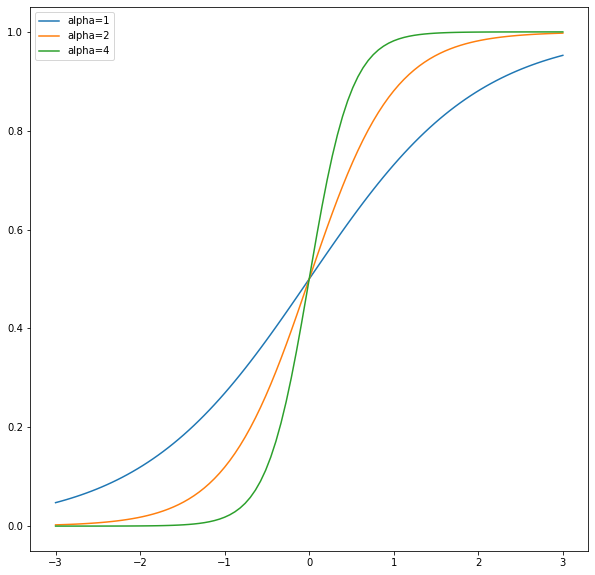

In [3]:
def sigm(a, x):
    return 1/(1+np.exp(-a*x))

plt.figure(figsize=(10,10))

data = np.linspace(-3,3,100)
alphas = [1,2,4]

for a in alphas:
    plt.plot(data, sigm(a,data))

plt.legend(['alpha=1', 'alpha=2', 'alpha=4'], loc='upper left')

    

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [4]:
from numpy import linalg
from sklearn.preprocessing import PolynomialFeatures

# funkcija za zadani primjer x i težine w vraća predikciju y = sigm(w^t*x)
def lr_h(x,w):
    poly = PolynomialFeatures(1)
    fi = poly.fit_transform(x.reshape(1,-1))
    # print(w.shape)
    # print(w)
    # print(fi.shape)
    # print(fi)
    y_pred_base = dot(np.transpose(w),fi[0])
    return sigm(1,y_pred_base)

# izračunava pogreške unakrsne entropije na označenom skupu (X,y) uz težine w
# ovdje ne množim sa faktorom (1/N) jer se to može ugraditi u alfu modela
# ali ako nešto nebude dobro radilo, dodaj taj faktor
# također pazi na onu pogrešku kad vrijednosti budu jako blizu 0, pa np to zaokruži na 0 i onda tražiš log(0)
# pa ako ti se to pojavi to riješi nekako
def cross_entropy_error(X,y,w):
    error = 0
    for i in range(len(X)):
        x_i = X[i]
        y_i = y[i]
        error += (-y_i*np.log(lr_h(x_i,w)) - (1-y_i)*np.log(1-lr_h(x_i,w)))
    return error

# dakle, ovo je funkcija koja će samo provesti treniranje i vratiti vektor težina w
# w je (n+1) dimenzijski jer ima i težinu w0, te težine w1...wn
# alpha predstavlja faktor L2 regularizacije - dakle treba je odmah ugraditi u model!
def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    step = 0
    second_to_last_iter_error = 1
    last_iter_error = 0
    #w0 = 0
    #w = np.zeros(len(X))
    # w sa uključenim w0 i w
    #w_tilda[0] = w0
    #w_tilda[1::] - w1...wn
    #print("Shape X: " + str(shape(X)))
    w_tilda = np.zeros(shape(X)[1] + 1)
    w_history = []
    
    while (max_iter > step and (abs(second_to_last_iter_error - last_iter_error) > epsilon)):
        step += 1
        delta_w0 = 0
        delta_w = np.zeros(shape(X)[1])
        for i in range(len(X)):
            x_i = X[i]
            y_i = y[i]
            h = lr_h(x_i,w_tilda)
            delta_w0 = delta_w0 - (h-y_i)
            delta_w = delta_w - (h-y_i)*x_i
        w_history.append(np.copy(w_tilda))
        w_tilda[0] = w_tilda[0] + eta*delta_w0
        w_tilda[1::] = w_tilda[1::]*(1-eta*alpha) + eta*delta_w
        second_to_last_iter_error = last_iter_error
        last_iter_error = cross_entropy_error(X,y,w_tilda)
        # print("Razlika između errora je: " + str((abs(second_to_last_iter_error - last_iter_error))))
    
    print("Završavam treniranje nakon " +  str(step) + " koraka")
    if (trace):
        return w_tilda,w_history
    else:
        return w_tilda

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

Završavam treniranje nakon 3105 koraka
Cross entropy error: 0.38222656941999567
Težine w: 
[ 7.73426648 -2.38474752  0.46232798]


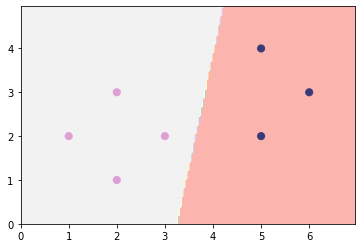

In [5]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])
#možda će trebati negdje napraviti reshape nad X, da se doda član x0, ne znam ili ovdje ili u b

# ukoliko stavim max_iter = 2000, prekine ga prije konvergencije
w, w_history = lr_train(seven_X, seven_y, max_iter = 4000, trace=True)
cer = cross_entropy_error(seven_X,seven_y,w)
print("Cross entropy error: " + str(cer))
print("Težine w: ")
print(w)
plot_2d_clf_problem(seven_X, seven_y, lambda x : lr_h(x,w) > 0.5)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [6]:
from sklearn.metrics import zero_one_loss

Završavam treniranje nakon 4000 koraka
Završavam treniranje nakon 3105 koraka
Završavam treniranje nakon 1544 koraka
Završavam treniranje nakon 1128 koraka


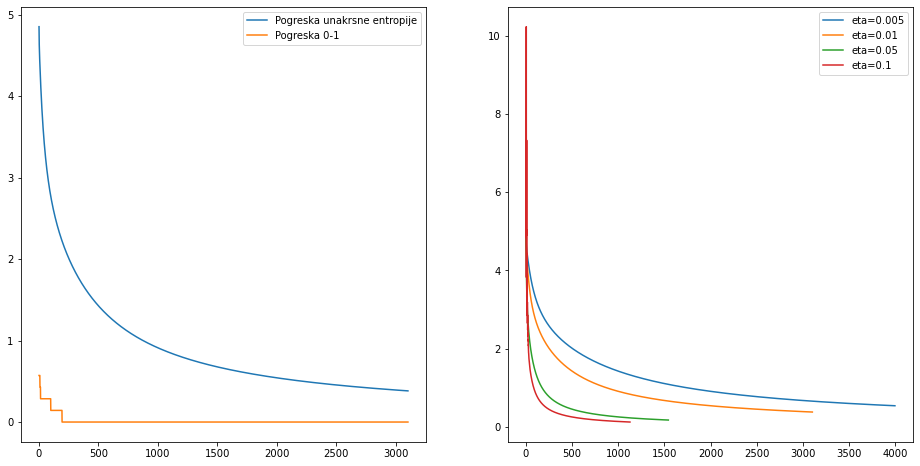

In [7]:
cross_entropy_errors = []
zero_one_errors = []

def predict(x):
    if x > 0.5:
        return 1
    else:
        return 0

plt.figure(figsize=(16,8))

for w_i in w_history:
    #print(w_i)
    cross_entropy_errors.append(cross_entropy_error(seven_X,seven_y,w_i))
    y_pred = []
    for i in range(len(seven_X)):
        if (lr_h(seven_X[i],w_i) > 0.5):
            y_pred.append(1)
        else:
            y_pred.append(0)
    zero_one_errors.append(zero_one_loss(seven_y, y_pred)) 

subplot(1,2,1)
plt.plot(cross_entropy_errors)
plt.plot(zero_one_errors)
legend(['Pogreska unakrsne entropije', 'Pogreska 0-1'], loc = 'upper right');


etas = [0.005, 0.01, 0.05, 0.1]

subplot(1,2,2)
for eta_i in etas:
    cross_entropy_errors = []
    w, w_history = lr_train(seven_X, seven_y, eta=eta_i, max_iter = 4000, trace=True)
    for w_i in w_history:
        cross_entropy_errors.append(cross_entropy_error(seven_X,seven_y,w_i))
    plt.plot(cross_entropy_errors)

legend(['eta=0.005', 'eta=0.01', 'eta=0.05', 'eta=0.1'], loc = 'upper right');


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

0-1 pogreška: 0.0


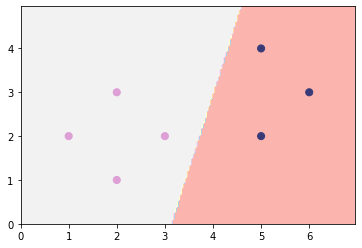

In [8]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='none',max_iter=4000, tol=0.0001).fit(seven_X,seven_y)
y_pred = []

for i in range (len(seven_X)):
    y_pred.append(model.predict(seven_X[i].reshape(1,-1)))

print("0-1 pogreška: " + str(zero_one_loss(seven_y, y_pred)))
plot_2d_clf_problem(seven_X,seven_y, lambda x : model.predict(x))

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

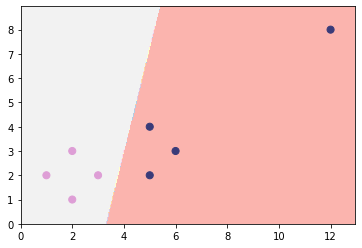

In [9]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

model = LogisticRegression(penalty='none',max_iter=4000, tol=0.0001).fit(outlier_X,outlier_y)
plot_2d_clf_problem(outlier_X,outlier_y, lambda x : model.predict(x))

In [10]:
# Vaš kôd ovdje

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

Završavam treniranje nakon 3105 koraka


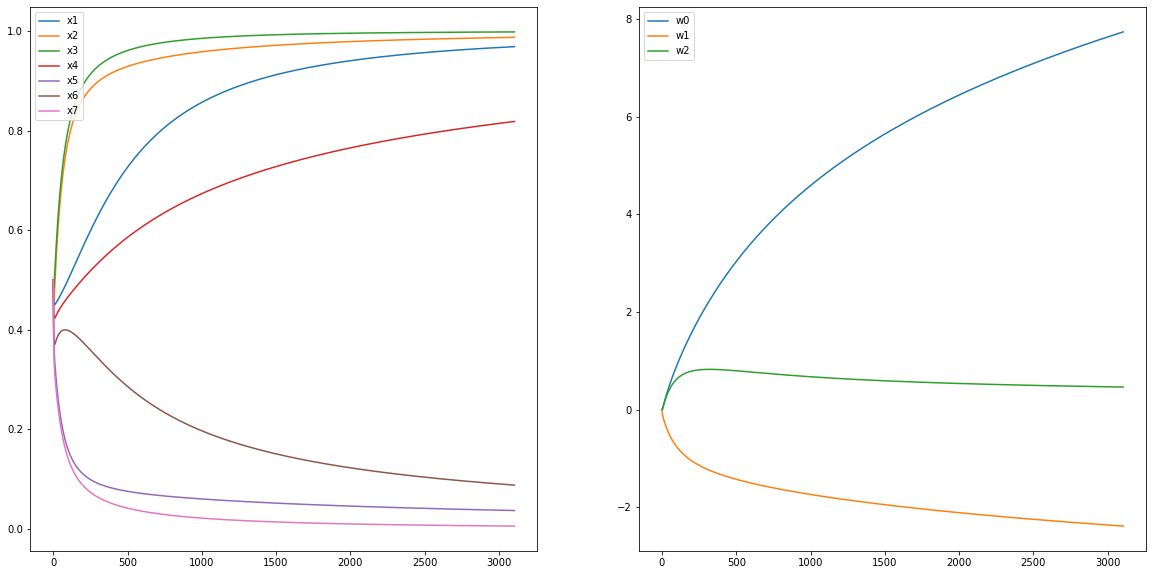

In [11]:
w0 = []
w1 = []
w2 = []

plt.figure(figsize=(20,10))

w, w_history = lr_train(seven_X, seven_y, max_iter = 4000, trace=True)
x_array = []

for i in range(len(seven_X)):
    x_array.append([])

for w_i in w_history:
    w0.append(w_i[0])
    w1.append(w_i[1])
    w2.append(w_i[2])
    
    for i in range(len(seven_X)):
        x_array[i].append(lr_h(seven_X[i],w_i))

plt.subplot(1,2,1)
legend_names = []
for i in range(len(x_array)):
    plt.plot(x_array[i])
    legend_names.append("x" + str(i+1))

legend(legend_names, loc = 'upper left');

plt.subplot(1,2,2)
plt.plot(w0)
plt.plot(w1)
plt.plot(w2)
legend(['w0','w1','w2'], loc='upper left')

    

# na prvom grafu vidimo kako vrijednosti koje se trebaju preslikati u 1 kako treniranje napreduje sve više se približavaju 1

        

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

Završavam treniranje nakon 1315 koraka


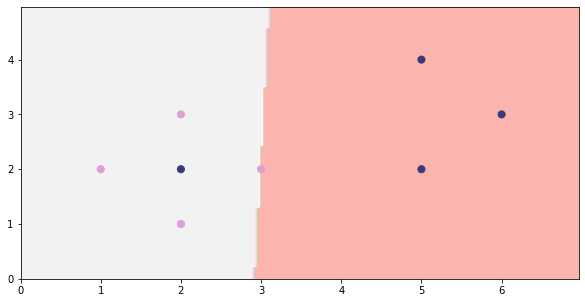

In [12]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

plt.figure(figsize=(10,5))
w, w_history = lr_train(unsep_X, unsep_y, max_iter = 4000, trace=True)
plot_2d_clf_problem(unsep_X, unsep_y, lambda x : lr_h(x,w) > 0.5)

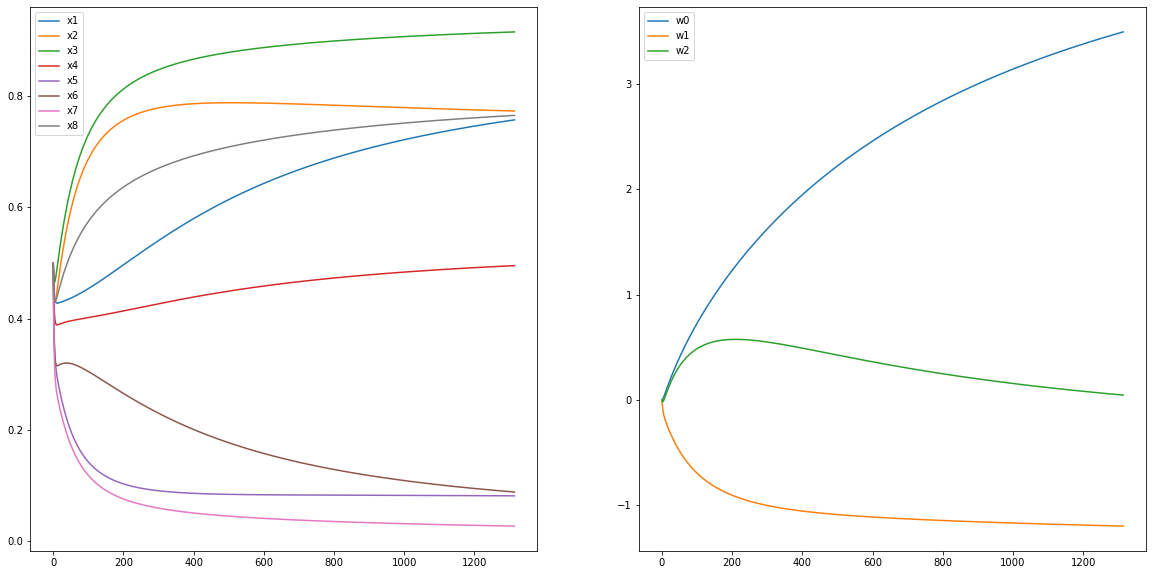

In [13]:
w0 = []
w1 = []
w2 = []

plt.figure(figsize=(20,10))
x_array = []

for i in range(len(unsep_X)):
    x_array.append([])

for w_i in w_history:
    w0.append(w_i[0])
    w1.append(w_i[1])
    w2.append(w_i[2])
    
    for i in range(len(unsep_X)):
        x_array[i].append(lr_h(unsep_X[i],w_i))

plt.subplot(1,2,1)
legend_names = []
for i in range(len(x_array)):
    plt.plot(x_array[i])
    legend_names.append("x" + str(i+1))

legend(legend_names, loc = 'upper left');

plt.subplot(1,2,2)
plt.plot(w0)
plt.plot(w1)
plt.plot(w2)
legend(['w0','w1','w2'], loc='upper left')        

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [14]:
from numpy.linalg import norm

Završavam treniranje nakon 3105 koraka
Završavam treniranje nakon 2052 koraka
Završavam treniranje nakon 772 koraka
Završavam treniranje nakon 230 koraka


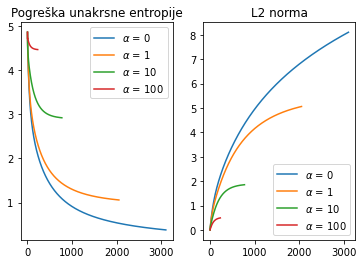

In [15]:
alphas = [0,1,10,100]
for i in range(len(alphas)):
    cross_entropy_errors = []
    w, w_history = lr_train(seven_X, seven_y, max_iter = 4000, alpha = alphas[i], trace=True)
    L2_norms = []
    for w_i in w_history:
        cross_entropy_errors.append(cross_entropy_error(seven_X,seven_y,w_i))
        # norm funkcija defaultno računa L2 normu
        L2_norms.append(norm(w_i))
    plt.subplot(1,2,1)
    plt.title("Pogreška unakrsne entropije")
    plt.plot(cross_entropy_errors, label = "$\\alpha$ = " + str(alphas[i]))
    plt.legend(loc = "upper right") ;

    plt.subplot(1,2,2)
    plt.title("L2 norma")
    plt.plot(L2_norms, label = "$\\alpha$ = " + str(alphas[i]))
    plt.legend(loc = "lower right")

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

Text(0.5, 1.0, 'd=3')

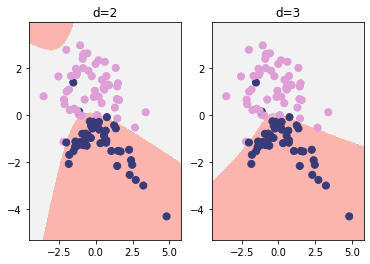

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2)
plot_2d_clf_problem(X, y)
title("Dvoklasan skup podataka")

poly2 = PolynomialFeatures(2)
poly3 = PolynomialFeatures(3)

fi_2 = poly2.fit_transform(X)
fi_3 = poly3.fit_transform(X)

model2 = LogisticRegression(penalty='none',max_iter=4000, tol=0.0001).fit(fi_2,y)
model3 = LogisticRegression(penalty='none',max_iter=4000, tol=0.0001).fit(fi_3,y)

plt.subplot(1,2,1)
plot_2d_clf_problem(X, y, lambda x : model2.predict(poly2.transform(x)))
plt.title("d=2")

plt.subplot(1,2,2)
plot_2d_clf_problem(X, y, lambda x : model3.predict(poly3.transform(x)))
plt.title("d=3")

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?